<a href="https://colab.research.google.com/github/BlackAngel2108/Pytorch_train/blob/main/MNIST_train.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
from sklearn.datasets import fetch_openml

# Загружаем данные из https://www.openml.org/d/554
X, y = fetch_openml('mnist_784', return_X_y = True, as_frame = False)

In [3]:
N, d = X.shape

In [4]:
def draw_digit(Img, digit_true, digit_pred = ''):
    plt.xticks([])
    plt.yticks([])
    plt.imshow(np.reshape(Img, (28, 28)))
    plt.text(0, 27, str(digit_true), color = 'b')
    plt.text(0, 1, str(digit_pred), color = 'r')
    plt.set_cmap('binary')
    #plt.set_cmap('gray')

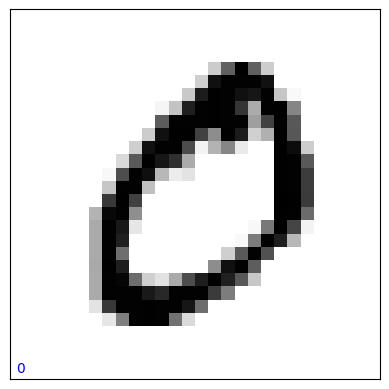

In [5]:
draw_digit(X[1, :], y[1])

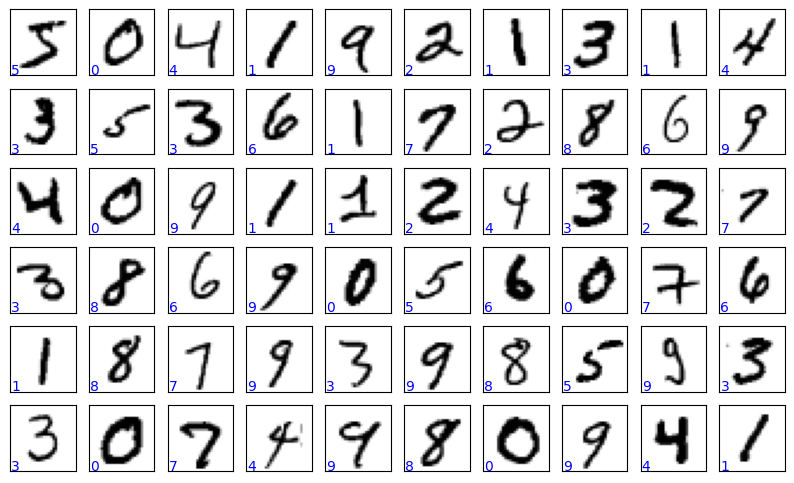

In [6]:
plt.figure(figsize = (10, 6))
for i_subplot in range(60):
    plt.subplot(6, 10, i_subplot + 1)
    draw_digit(X[i_subplot, :], y[i_subplot])

In [7]:
N_test = 10000
N_train = X.shape[0] - N_test

In [8]:
N_test, N_train

(10000, 60000)

In [9]:
N_test = 1000
N_train = 6000

In [10]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    train_size = N_train, test_size = N_test,
                                                    stratify = y, random_state = 42)

**Torch Linear**

In [32]:
import torch # библиотека нейронных сетей
import torch.nn as nn # модуль слоёв
import numpy as np

In [34]:
model = nn.Sequential(
    nn.Linear(d, 50),
    nn.ReLU(),
    nn.Linear(50, 10)
)
model

Sequential(
  (0): Linear(in_features=784, out_features=50, bias=True)
  (1): ReLU()
  (2): Linear(in_features=50, out_features=10, bias=True)
)

In [35]:
loss_function = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())

In [33]:
from torch.utils.data import TensorDataset, DataLoader

In [29]:
def train(model, X_train, y_train, loss_function, optimizer,
          batch_size=16, epochs=16, verbose=True, device='cpu'):
    # Преобразуем метки в числовой формат
    if y_train.dtype == np.object_ or y_train.dtype == np.str_:
        # Если метки строковые - преобразуем в числа
        from sklearn.preprocessing import LabelEncoder
        le = LabelEncoder()
        y_train = le.fit_transform(y_train)

    X_tensor = torch.FloatTensor(X_train)
    y_tensor = torch.LongTensor(y_train.astype(np.int64))  # Явное указание типа

    dataset = TensorDataset(X_tensor, y_tensor)
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

    model.train()
    model.to(device)

    for epoch in range(epochs):
        losses = []
        for X_batch, y_batch in dataloader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)

            logits = model(X_batch)
            loss = loss_function(logits, y_batch)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            losses.append(loss.item())

        if verbose:
            print(f'Epoch {epoch+1}/{epochs}, Loss: {np.mean(losses):.4f}')

In [36]:
train(model, X_train, y_train, loss_function, optimizer)

Epoch 1/16, Loss: 1.7622
Epoch 2/16, Loss: 0.5333
Epoch 3/16, Loss: 0.3578
Epoch 4/16, Loss: 0.3017
Epoch 5/16, Loss: 0.2904
Epoch 6/16, Loss: 0.2300
Epoch 7/16, Loss: 0.2081
Epoch 8/16, Loss: 0.1914
Epoch 9/16, Loss: 0.1803
Epoch 10/16, Loss: 0.2549
Epoch 11/16, Loss: 0.1611
Epoch 12/16, Loss: 0.1555
Epoch 13/16, Loss: 0.1915
Epoch 14/16, Loss: 0.1562
Epoch 15/16, Loss: 0.1952
Epoch 16/16, Loss: 0.1361


In [16]:
from sklearn.metrics import confusion_matrix, accuracy_score

def print_confusion_matrix(model, X, y):
    model.eval()
    y_pred = model(torch.Tensor(X)).data.numpy().argmax(axis = 1)
    print(confusion_matrix(y, y_pred))
    accuracy = accuracy_score(y, y_pred)
    print(f"Accuracy = {accuracy}")
    return accuracy

In [17]:
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.preprocessing import LabelEncoder

def print_confusion_matrix(model, X, y):
    model.eval()

    # Преобразуем строковые метки в числа (если они строки)
    if isinstance(y[0], str):
        le = LabelEncoder()
        y_encoded = le.fit_transform(y)
    else:
        y_encoded = y

    with torch.no_grad():
        y_pred = model(torch.Tensor(X)).argmax(dim=1).numpy()

    print("Confusion Matrix:")
    print(confusion_matrix(y_encoded, y_pred))

    accuracy = accuracy_score(y_encoded, y_pred)
    print(f"Accuracy = {accuracy:.4f}")
    return accuracy

print_confusion_matrix(model, X_test, y_test)

Confusion Matrix:
[[56  4 22  0  0  4  3  0  5  5]
 [43  0 48  1  0  3  5  0  3 10]
 [60  3 20  0  2  4  5  0  4  2]
 [29  3 33  7  0 15  3  0  8  4]
 [49  3 14  0  6  7  4  0 13  1]
 [30  1 14  0  0  8  3  1 27  6]
 [58  2 16  0  0  1  3  0 18  0]
 [40  2 23  6  0  2  5  0 20  6]
 [69  0 14  1  0  7  3  0  2  2]
 [31  3 41  0  0  6  0  0 15  3]]
Accuracy = 0.1050


0.105

**CNN**

In [37]:
batch_size = 64

In [38]:

from torchvision import datasets, transforms
train_dataset = datasets.MNIST(root='./data/', train=True,  transform=transforms.ToTensor(), download=True)
test_dataset  = datasets.MNIST(root='./data/', train=False, transform=transforms.ToTensor())

from torch.utils.data import DataLoader

batch_size = 64

train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
test_loader  = DataLoader(dataset=test_dataset,  batch_size=batch_size, shuffle=False)

100%|██████████| 9.91M/9.91M [00:00<00:00, 37.5MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 1.18MB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 9.05MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 4.11MB/s]


In [39]:
model = nn.Sequential(
    nn.Conv2d(in_channels = 1, out_channels = 8, kernel_size = 3), # 26x26
    nn.MaxPool2d(kernel_size = 2), # 13x13
    nn.ReLU(),
    nn.Conv2d(in_channels = 8, out_channels = 16, kernel_size = 5), # 9x9
    nn.MaxPool2d(kernel_size = 3), # 3x3
    nn.ReLU(),
    nn.Flatten(),
    nn.Linear(in_features = 16*3*3, out_features = 32),
    nn.ReLU(),
    nn.Linear(32, 10)
)
model

Sequential(
  (0): Conv2d(1, 8, kernel_size=(3, 3), stride=(1, 1))
  (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (2): ReLU()
  (3): Conv2d(8, 16, kernel_size=(5, 5), stride=(1, 1))
  (4): MaxPool2d(kernel_size=3, stride=3, padding=0, dilation=1, ceil_mode=False)
  (5): ReLU()
  (6): Flatten(start_dim=1, end_dim=-1)
  (7): Linear(in_features=144, out_features=32, bias=True)
  (8): ReLU()
  (9): Linear(in_features=32, out_features=10, bias=True)
)

In [40]:
loss_function = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())

In [41]:
def train(epoch):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        optimizer.zero_grad()
        output = model(data)
        loss = loss_function(output, target)
        loss.backward()
        optimizer.step()
        if batch_idx % 100 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))

In [42]:
def test():
    model.eval()
    test_loss = 0
    correct = 0
    for data, target in test_loader:
        output = model(data)
        test_loss += loss_function(output, target).data
        pred = output.data.max(1, keepdim=True)[1]
        correct += pred.eq(target.data.view_as(pred)).cpu().sum()

    test_loss /= len(test_loader.dataset)
    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))


In [44]:
for epoch in range(5):
    train(epoch + 1)
    test()

Train Epoch: 1 [0/60000 (0%)]	Loss: 0.052433
Train Epoch: 1 [6400/60000 (11%)]	Loss: 0.119119
Train Epoch: 1 [12800/60000 (21%)]	Loss: 0.116481
Train Epoch: 1 [19200/60000 (32%)]	Loss: 0.054209
Train Epoch: 1 [25600/60000 (43%)]	Loss: 0.017662
Train Epoch: 1 [32000/60000 (53%)]	Loss: 0.214112
Train Epoch: 1 [38400/60000 (64%)]	Loss: 0.018992
Train Epoch: 1 [44800/60000 (75%)]	Loss: 0.058512
Train Epoch: 1 [51200/60000 (85%)]	Loss: 0.116825
Train Epoch: 1 [57600/60000 (96%)]	Loss: 0.112106

Test set: Average loss: 0.0011, Accuracy: 9787/10000 (97.87%)

Train Epoch: 2 [0/60000 (0%)]	Loss: 0.127129
Train Epoch: 2 [6400/60000 (11%)]	Loss: 0.033580
Train Epoch: 2 [12800/60000 (21%)]	Loss: 0.073726
Train Epoch: 2 [19200/60000 (32%)]	Loss: 0.038826
Train Epoch: 2 [25600/60000 (43%)]	Loss: 0.087444
Train Epoch: 2 [32000/60000 (53%)]	Loss: 0.048287
Train Epoch: 2 [38400/60000 (64%)]	Loss: 0.074556
Train Epoch: 2 [44800/60000 (75%)]	Loss: 0.112832
Train Epoch: 2 [51200/60000 (85%)]	Loss: 0.11832

In [45]:
def print_confusion_matrix(loader):
    model.eval()

    confusion_matrix = torch.zeros(10, 10, dtype=torch.int)
    for data, target in loader:
        output = model(data)
        _, preds = torch.max(output, 1)
        for t, p in zip(target.view(-1), preds.view(-1)):
                confusion_matrix[t.long(), p.long()] += 1
    print(confusion_matrix)
    accuracy = confusion_matrix.diagonal().sum()/confusion_matrix.sum()
    print(f"Accuracy = {100*accuracy:.2f}%")

In [46]:
print_confusion_matrix(test_loader)

tensor([[ 967,    0,    1,    0,    0,    0,    8,    2,    1,    1],
        [   0, 1132,    1,    0,    0,    0,    0,    2,    0,    0],
        [   2,    5, 1010,    2,    1,    0,    1,    8,    3,    0],
        [   1,    0,    1,  998,    0,    2,    0,    6,    2,    0],
        [   1,    1,    1,    0,  970,    0,    1,    2,    0,    6],
        [   2,    0,    0,    8,    0,  871,    6,    1,    1,    3],
        [   2,    3,    0,    1,    1,    1,  948,    0,    2,    0],
        [   0,    5,    3,    0,    0,    0,    0, 1014,    2,    4],
        [   1,    1,    2,    1,    5,    0,    6,    3,  951,    4],
        [   1,    4,    0,    1,    7,    1,    1,    3,    3,  988]],
       dtype=torch.int32)
Accuracy = 98.49%


**Multi Layer Perceptron**

In [18]:
from sklearn.neural_network import MLPClassifier
model = MLPClassifier(hidden_layer_sizes = (30,), random_state = 42)
model.fit(X_train, y_train)

MLPClassifier(hidden_layer_sizes=(30,), random_state=42)

In [19]:
y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)
np.mean(y_train != y_train_pred), np.mean(y_test != y_test_pred)

(np.float64(0.03216666666666667), np.float64(0.124))

In [20]:
model = MLPClassifier(hidden_layer_sizes = (1000, 500), random_state = 42)
model.fit(X_train, y_train)

MLPClassifier(hidden_layer_sizes=(1000, 500), random_state=42)

In [21]:

y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)
np.mean(y_train != y_train_pred), np.mean(y_test != y_test_pred)

(np.float64(0.0), np.float64(0.071))

In [22]:
alpha_arr = np.logspace(-4, 5, 10)
train_err = []
test_err = []
for alpha in alpha_arr:
    mlp_model = MLPClassifier(hidden_layer_sizes = (30,), random_state = 42, alpha = alpha)
    mlp_model.fit(X_train, y_train)

    y_train_pred = mlp_model.predict(X_train)
    y_test_pred = mlp_model.predict(X_test)
    train_err.append(np.mean(y_train != y_train_pred))
    test_err.append(np.mean(y_test != y_test_pred))

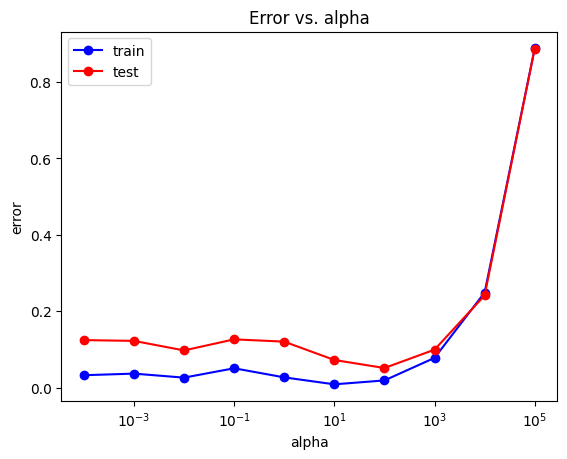

In [23]:
plt.semilogx(alpha_arr, train_err, 'b-o', label = 'train')
plt.semilogx(alpha_arr, test_err, 'r-o', label = 'test')
#plt.xlim([np.max(alpha_arr), np.min(alpha_arr)])
plt.title('Error vs. alpha')
plt.xlabel('alpha')
plt.ylabel('error')
plt.legend()
pass

In [24]:
min_train_err = np.min(train_err)
min_test_err = np.min(test_err)
print(min_train_err, min_test_err)

0.008333333333333333 0.051


In [25]:
alpha_opt = alpha_arr[test_err == min_test_err]
print(alpha_opt)

[100.]


In [26]:
alpha_opt = alpha_opt[0]

In [27]:
mlp_model = MLPClassifier(hidden_layer_sizes = (30,), random_state = 42, alpha = alpha_opt)
mlp_model.fit(X_train, y_train)

y_train_pred = mlp_model.predict(X_train)
y_test_pred = mlp_model.predict(X_test)
print(np.mean(y_train != y_train_pred))
print(np.mean(y_test != y_test_pred))

0.0185
0.051


**Support vector machine**

In [47]:
from sklearn.svm import SVC
model = SVC()
model.fit(X_train, y_train)

SVC()

In [48]:
y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)
np.mean(y_train != y_train_pred), np.mean(y_test != y_test_pred)

(np.float64(0.016833333333333332), np.float64(0.041))

In [49]:
model = SVC(kernel = 'linear')
model.fit(X_train, y_train)

SVC(kernel='linear')

In [50]:
model = SVC(kernel = 'linear')
model.fit(X_train, y_train)
y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)
np.mean(y_train != y_train_pred), np.mean(y_test != y_test_pred)

(np.float64(0.0), np.float64(0.089))

In [51]:
model = SVC(kernel = 'poly')
model.fit(X_train, y_train)

SVC(kernel='poly')

In [52]:
y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)
np.mean(y_train != y_train_pred), np.mean(y_test != y_test_pred)

(np.float64(0.014666666666666666), np.float64(0.052))

**Logistic regression**


In [53]:
from sklearn.linear_model import LogisticRegression
model = LogisticRegression(max_iter=500)
model.fit(X_train, y_train)

LogisticRegression(max_iter=500)

In [54]:
y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)
np.mean(y_train != y_train_pred), np.mean(y_test != y_test_pred)

(np.float64(0.0), np.float64(0.128))